Requirements:

Conduct your analysis using a cross-validation design.
Conduct / improve upon previous EDA.
Build the following models at a minimum:      
Random Forest Classifier  
Gradient Boosted Trees  
Extra Trees  
Conduct hyperparameter tuning for the following at a minimum:  
n_estimators (number of trees)  
max_features (maximum features considered for splitting a node)  
max_depth (maximum number of levels in each tree)  
splitting criteria (entropy or gini)  
Compare your models using the F1-Score on a 20% validation set.  
Generate predictions from your models, and submit at least two models to Kaggle.com for evaluation.  
Provide your Kaggle.com user name and a screen snapshot of your scores.

In [ ]:
#Libraries
#https://drive.google.com/drive/folders/1Guk1eiIYwPEysI4SqfZ45lnPp4a4SwoV

import numpy as np 
import pandas as pd 
from math import sqrt

import os

import statsmodels.formula.api as sm
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # Random Forest package
from sklearn.ensemble import ExtraTreesClassifier # Extra Trees package

from sklearn.metrics import mean_squared_error, r2_score ,make_scorer, accuracy_score, roc_auc_score, roc_curve 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

!pip install scikit-plot
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.getcwd()
%cd /content/gdrive/My Drive/ML_Assignment5/
!pwd
!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/gdrive/My Drive/ML_Assignment5/"

/content/gdrive/My Drive/ML_Assignment5
/content/gdrive/My Drive/ML_Assignment5
Assignment5_Stevenson.ipynb  data.csv  Log_ROC.png
Working Directory
/content/gdrive/My Drive/ML_Assignment5


In [ ]:
#Reading Data into data frame
data_raw = pd.read_csv(work_dir +'data.csv')
print(data_raw)
data_copy = data_raw.copy()

      Bankrupt?  ...   Equity to Liability
0             1  ...              0.016469
1             1  ...              0.020794
2             1  ...              0.016474
3             1  ...              0.023982
4             1  ...              0.035490
...         ...  ...                   ...
6814          0  ...              0.029890
6815          0  ...              0.038284
6816          0  ...              0.097649
6817          0  ...              0.044009
6818          0  ...              0.233902

[6819 rows x 96 columns]


In [ ]:
data_copy.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
data_copy.shape

(6819, 96)

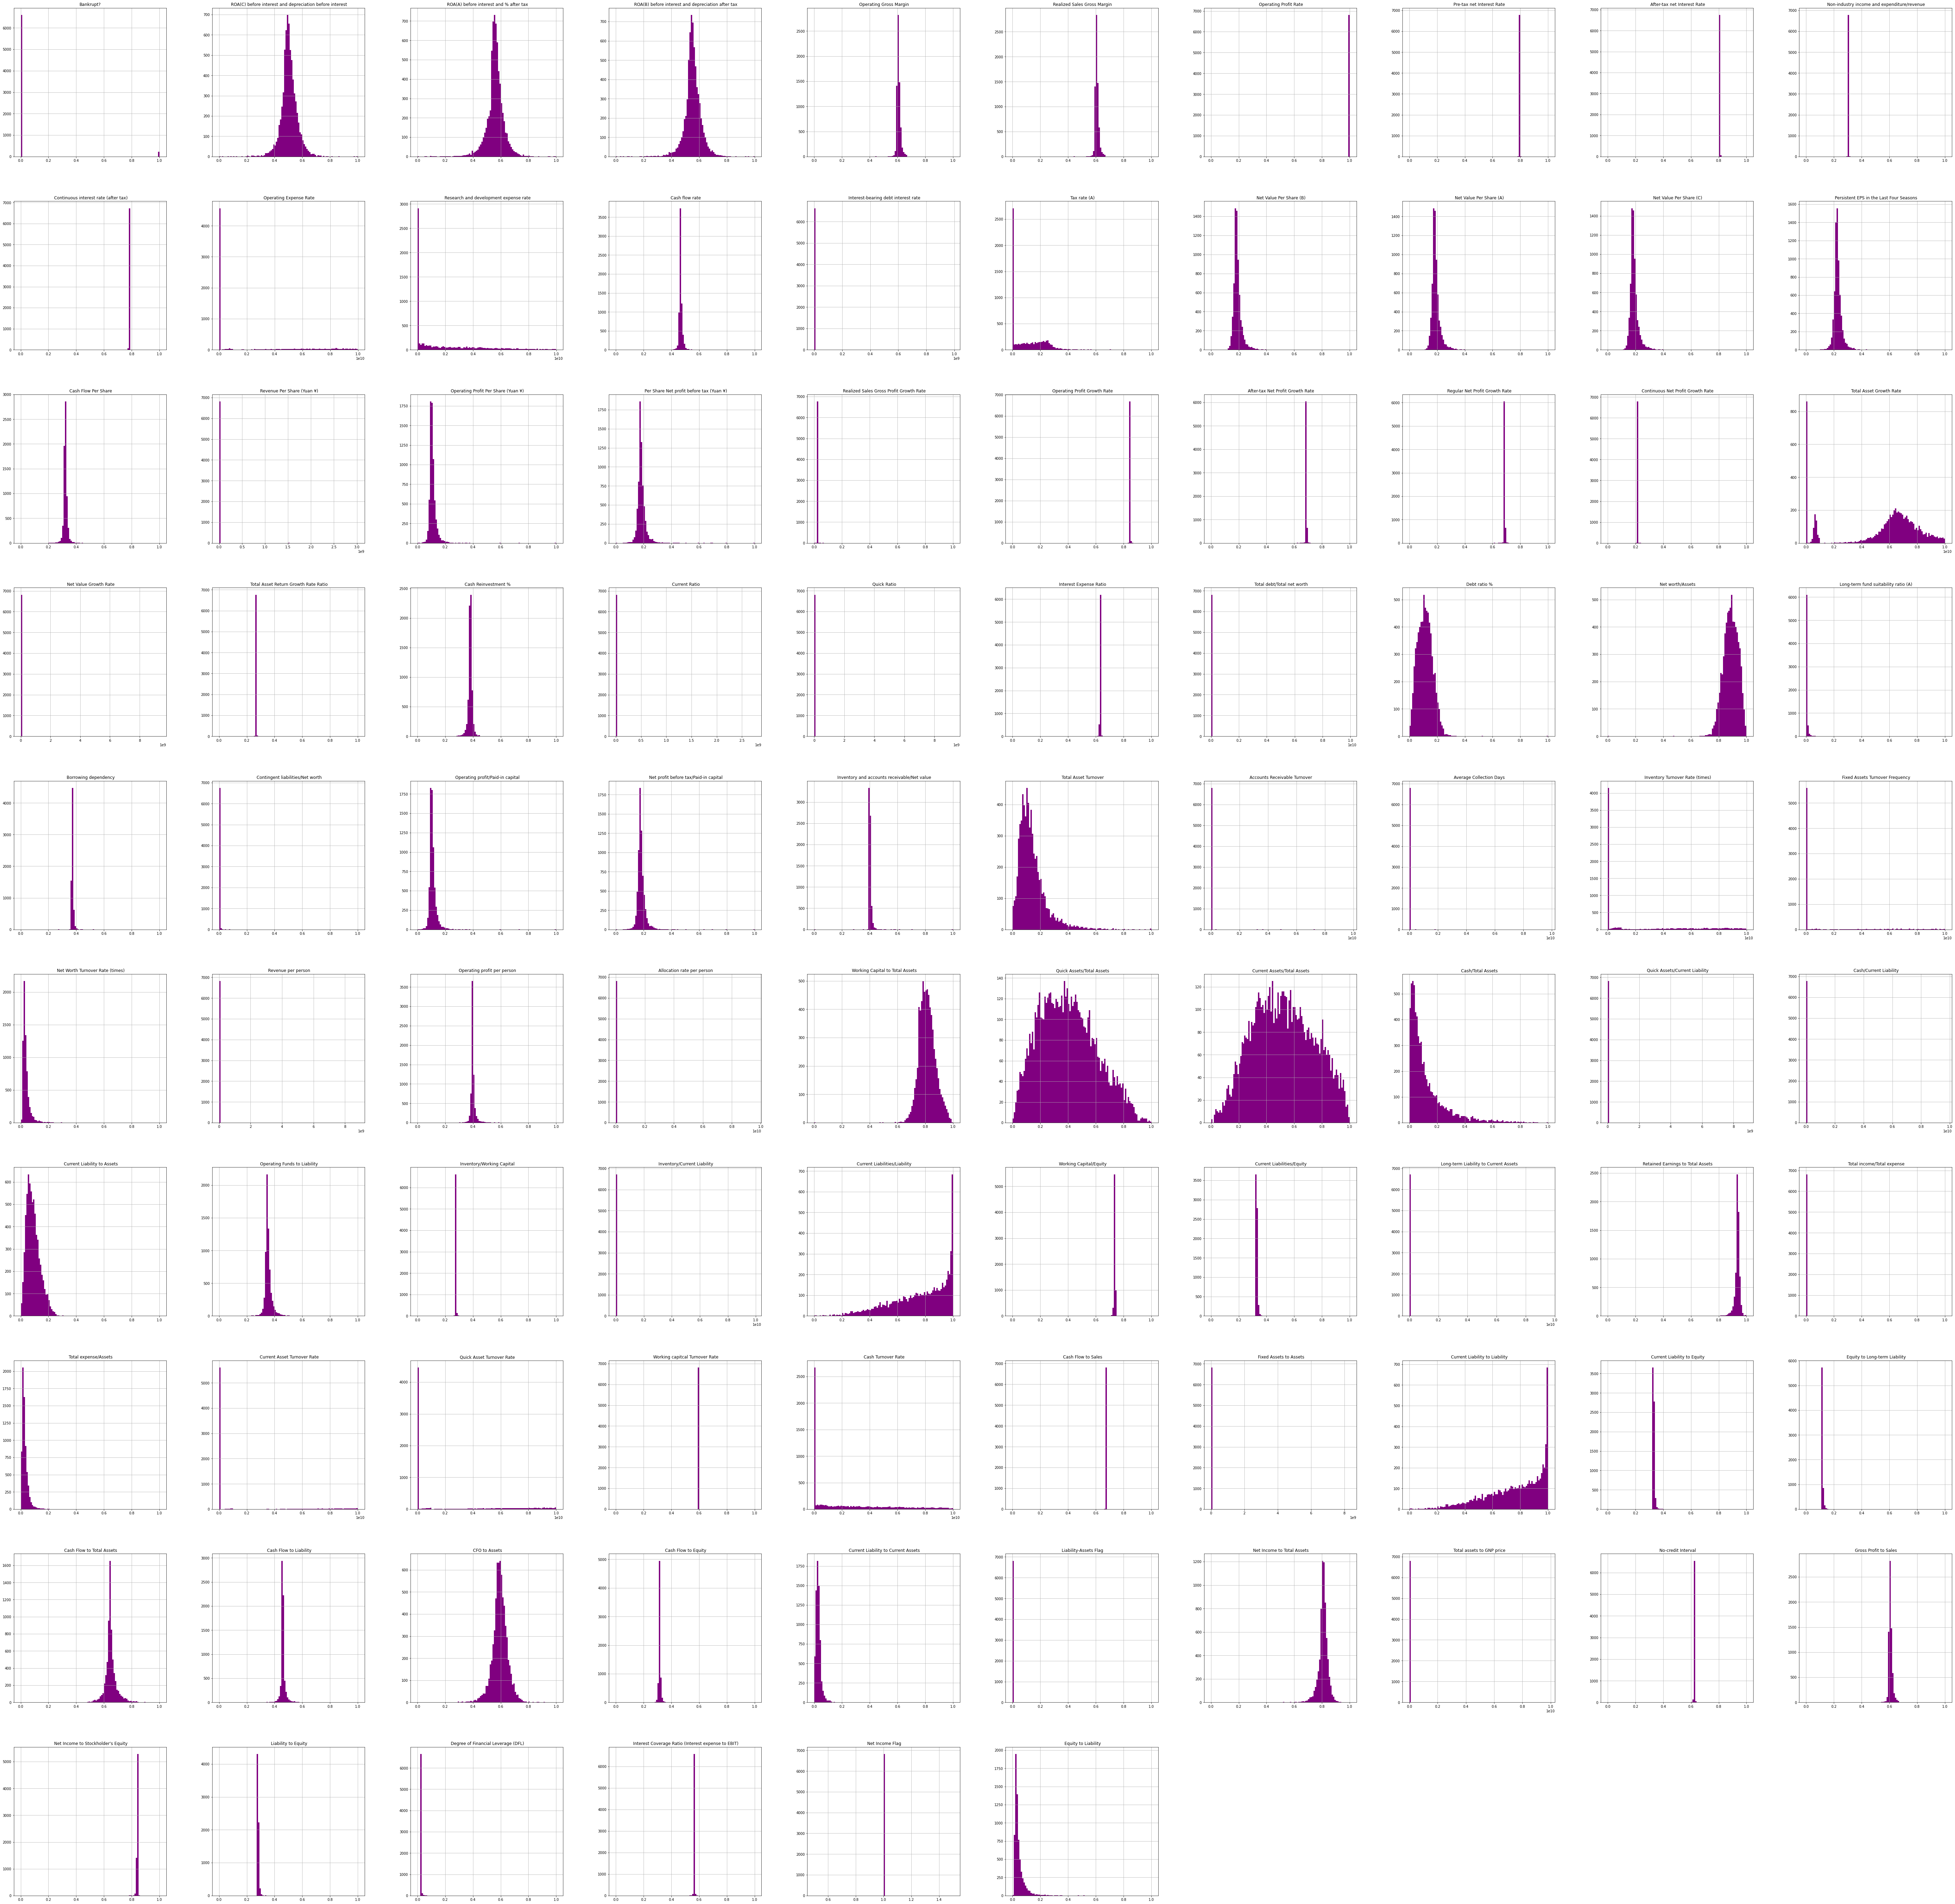

In [ ]:
data_copy.hist(bins=100, figsize=(100,100),color='purple')
plt.show()

In [ ]:
data_copy['Bankrupt?'].describe()

count    6819.000000
mean        0.032263
std         0.176710
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Bankrupt?, dtype: float64

In [ ]:
data_copy['Bankrupt?'].value_counts(1)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

In [ ]:
data_copy.isnull().sum().any()

False

In [ ]:
# Printing numeric columns and how many there are
num_cols = data_copy._get_numeric_data().columns 
display(num_cols)
print("Count: ", len(num_cols))

AttributeError: ignored

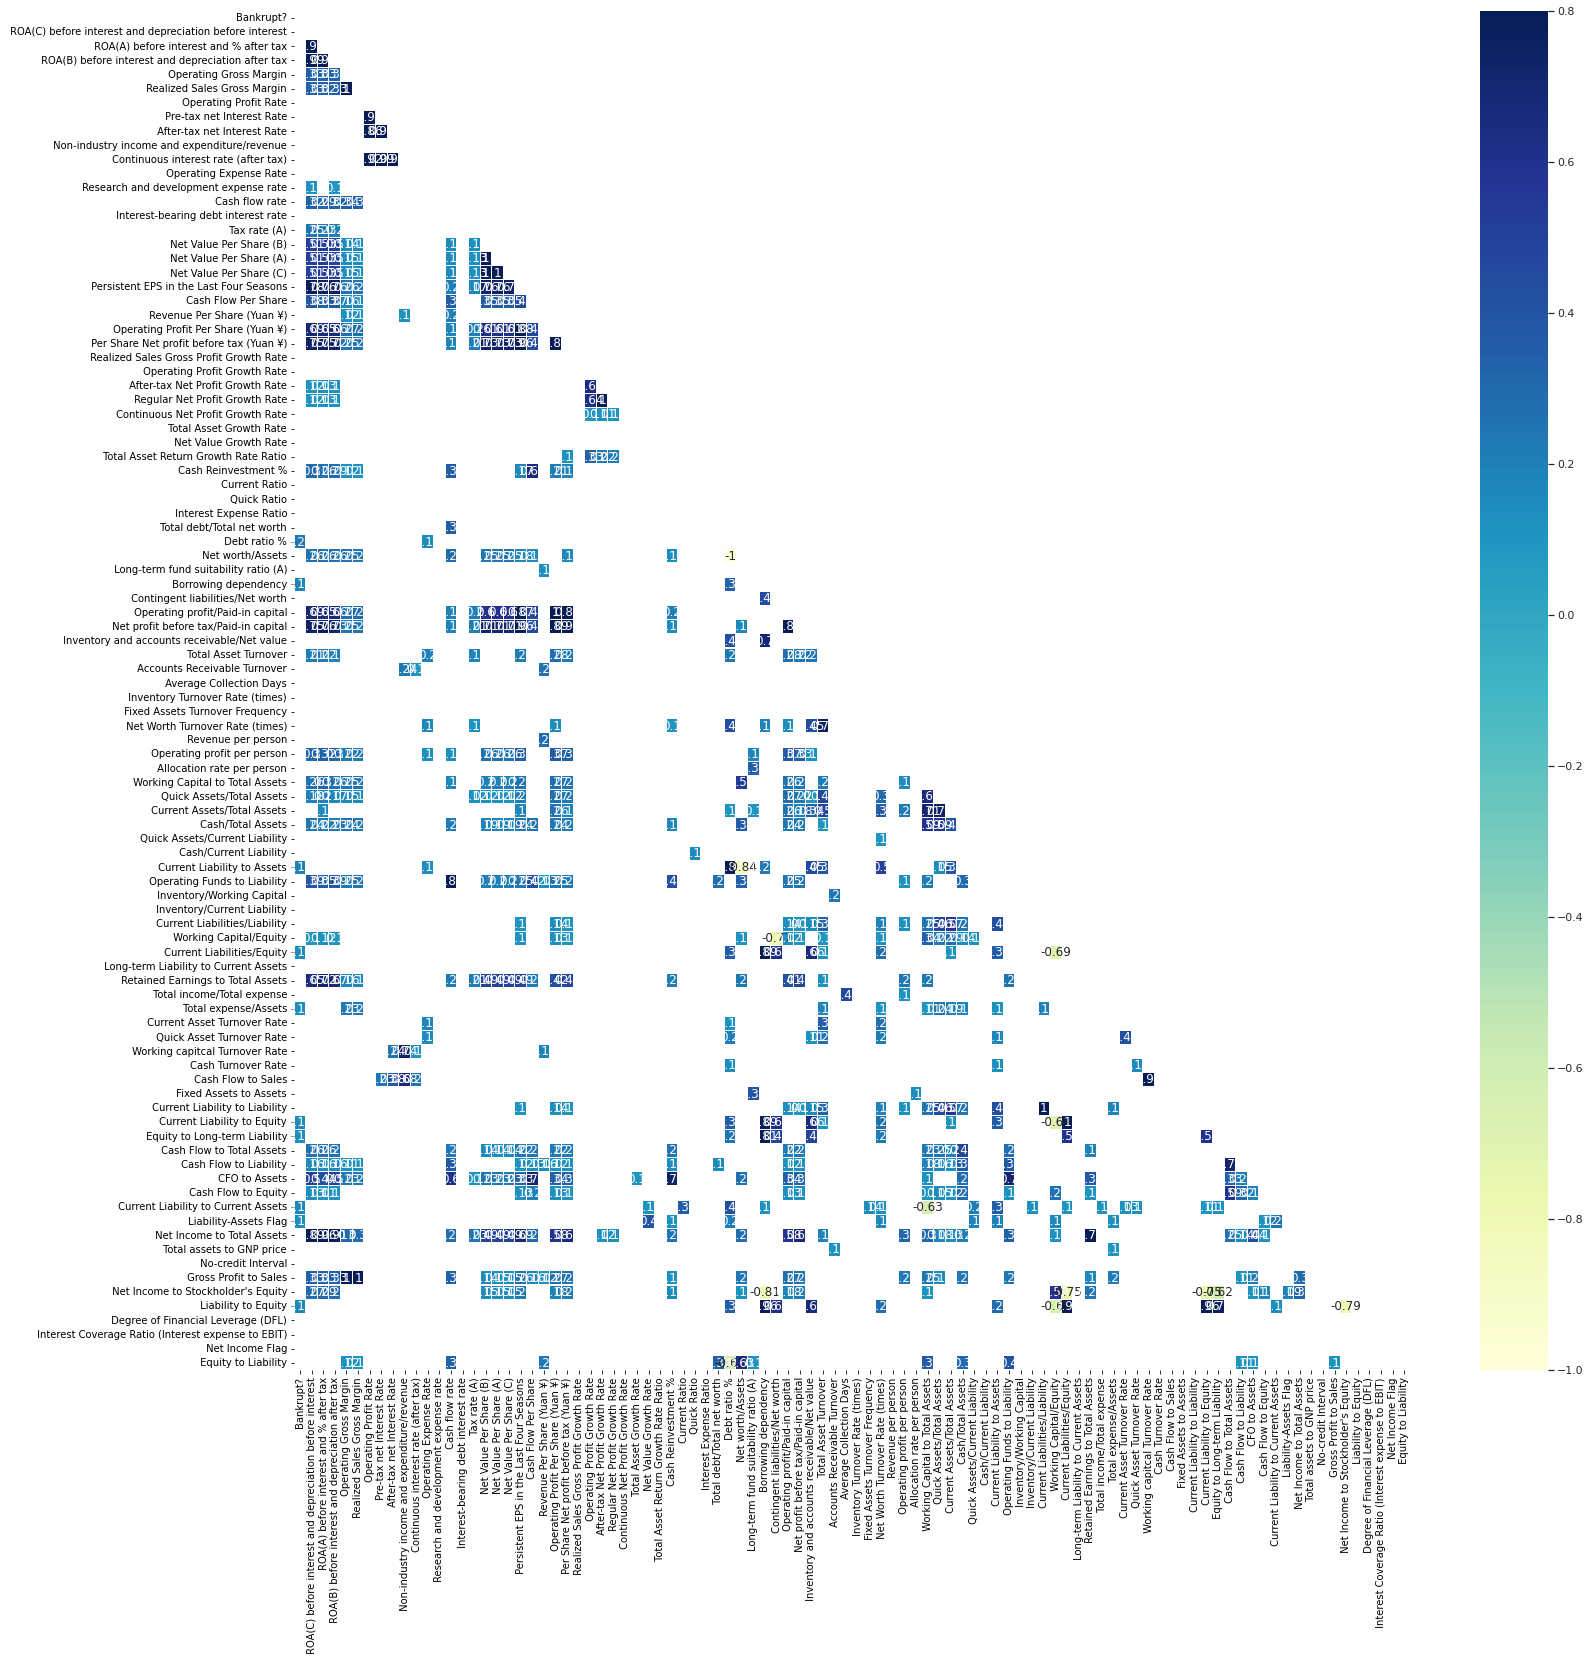

In [ ]:
# Checking Correlation 
corrmat = data_copy.corr()
fig, ax = plt.subplots(figsize=(25,25))  
matrix = np.triu(data_copy.corr())
color = sns.color_palette("YlGnBu", as_cmap=True)
sns.set(font_scale=1)
sns.heatmap(corrmat[(corrmat >= 0.1) | (corrmat <= -0.6)], annot=True,vmax=.8, mask=matrix, ax=ax,cmap = color,linewidths=0.1);

In [ ]:
data_copy.corr()['Bankrupt?'][(data_copy.corr()['Bankrupt?']>0.1) & (data_copy.corr()['Bankrupt?']<1)]

 Debt ratio %                           0.250161
 Borrowing dependency                   0.176543
 Current Liability to Assets            0.194494
 Current Liabilities/Equity             0.153828
 Total expense/Assets                   0.139049
 Current Liability to Equity            0.153828
 Equity to Long-term Liability          0.139014
 Current Liability to Current Assets    0.171306
 Liability-Assets Flag                  0.139212
 Liability to Equity                    0.166812
Name: Bankrupt?, dtype: float64

In [ ]:
ntrain = data_copy.shape[0]
#Creating a data frame that will still include Bankrupt?
y_train = data_copy['Bankrupt?'].values
#Dropping Bankrupt? column
data_train=data_copy.drop(['Bankrupt?'], axis=1)
print("all_data size is : {}".format(data_train.shape))

all_data size is : (6819, 95)


In [ ]:
train_scale = data_train.copy()
train_minmax = data_train.copy()

# train_scale[train_scale.columns]=preprocessing.scale(train_scale[train_scale.columns])

# # define min max scaler
# scaler = MinMaxScaler()
# train_minmax[train_minmax.columns] = scaler.fit_transform(train_minmax[train_minmax.columns])

# display(data_train.head())
# display(train_scale.head())
# display(train_minmax.head())
# print("Plain data:")

# # Drawing box plots to check for outliers
# plt.figure(figsize = (130,15))
# data_train.boxplot()
# print("Scaled data:")

# # Drawing box plots to check for outliers
# plt.figure(figsize = (130,15))
# train_scale.boxplot()
# print("Minmax scaled data:")

# # Drawing box plots to check for outliers
# plt.figure(figsize = (130,15))
# train_minmax.boxplot()

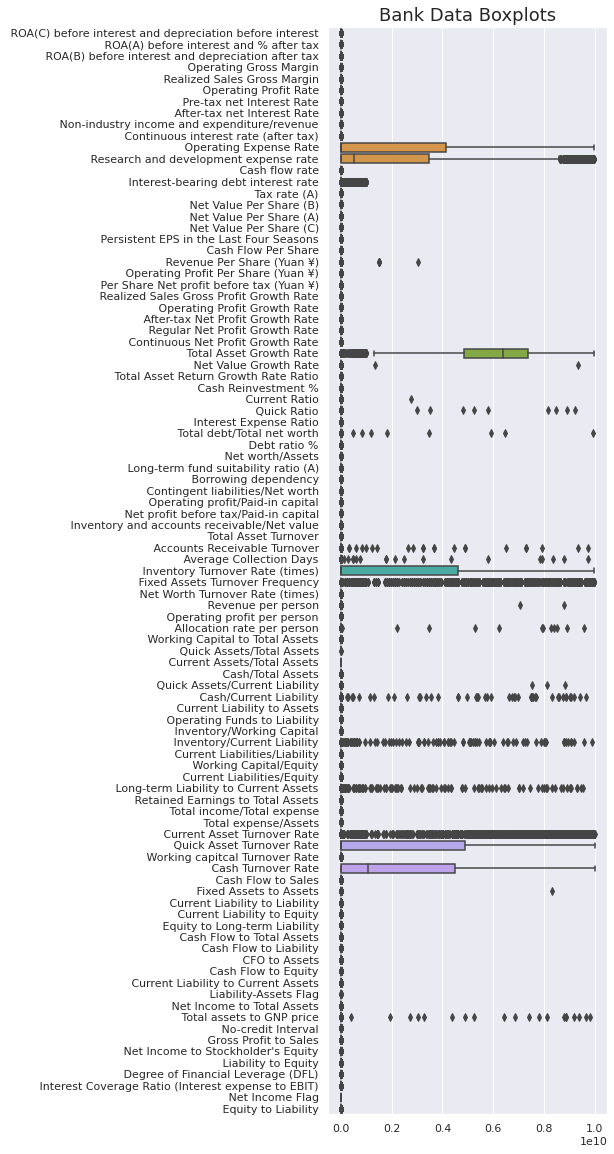

In [ ]:
# Plotting Boxplots of the numerical features
plt.figure(figsize = (5,20))
ax =sns.boxplot(data = data_train, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
plt.show()

2. Split the training set into an 80% training and 20% validation set

In [ ]:
#splitting data in to train and validation sets
train_scale['Bankrupt?'] = y_train

# train-test 80-20 split
train_reg, test_reg = train_test_split(train_scale, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 13)

# Divide into X_train, y_train, X_test, y_test
y_train_1 = train_reg.pop('Bankrupt?')
X_train_1 = train_reg

y_test_1 = test_reg.pop('Bankrupt?')
X_test_1 = test_reg

In [ ]:
#Dataset to be used in models
model_columns=X_train_1.columns
model_columns

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate'

Functions for Model Support Analysis

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
def acc_score(model, input_data, output_data):
    return np.mean(cross_val_score(model,input_data,output_data,cv=k_fold,scoring="accuracy"))

In [ ]:
def aucscore(model, input_data, output_data, has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(output_data,model.predict_proba(input_data)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(output_data,model.decision_function(input_data))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc

In [ ]:
def plt_roc_curve(name, model, input_data, output_data, has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(output_data,model.predict_proba(input_data)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(output_data,model.decision_function(input_data))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Train Data)")
    plt.legend(loc="lower right")
    plt.show()

Hyperparameter Config

In [ ]:
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None],
    "max_features":[1,2,3,5,8,13,21],
    "criterion":["gini","entropy"]  
}

# cv = GridSearchCV(rfc,parameters,cv=5)
# cv.fit(train_features,train_label.values.ravel())

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

3. Build the following models at a minimum:  
Random Forest Classifier  
Gradient Boosted Trees  
Extra Trees

In [ ]:
#Random Forest Classifier
randreg_init = RandomForestClassifier();

cvrf = GridSearchCV(randreg_init,parameters,cv=5)
cvrf.fit(X_train_1,y_train_1.values.ravel())
display(cvrf)

#Based on parameter tuning above
randreg = RandomForestClassifier(n_estimators=100,max_depth=8, criterion="gini", max_features=13);
randreg.fit(X_train_1,y_train_1)

y_predicted_randreg = randreg.predict(X_test_1)


Best parameters are: {'criterion': 'gini', 'max_depth': 32, 'max_features': 13, 'n_estimators': 250}


0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 5}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 10}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 50}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 100}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 250}
0.969 + or -0.001 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 5}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_est

In [ ]:
print("Accuracy: " + str(acc_score(randreg, X_train_1, y_train_1)))
#confusion_matrix_model(log_reg, x_train, y_train)

Accuracy: 0.9712190650779101


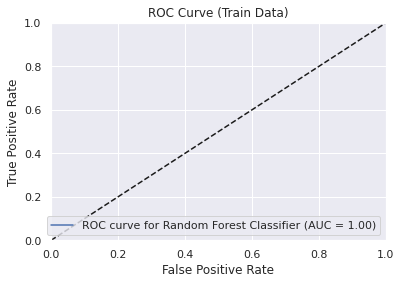

In [ ]:
plt_roc_curve("Random Forest Classifier",randreg, X_train_1, y_train_1, has_proba=True)

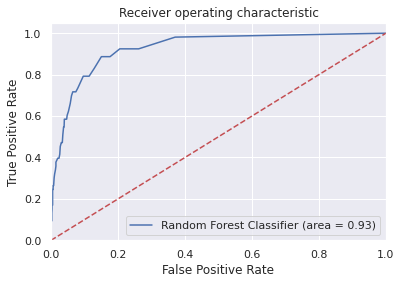

In [ ]:
logit_roc_auc = roc_auc_score(y_test_1, randreg.predict_proba(X_test_1)[:,1])
fpr, tpr, thresholds = roc_curve(y_test_1, randreg.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Accuracy: 0.9710357470210816
Classification Report               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1311
           1       0.62      0.19      0.29        53

    accuracy                           0.96      1364
   macro avg       0.80      0.59      0.64      1364
weighted avg       0.95      0.96      0.95      1364



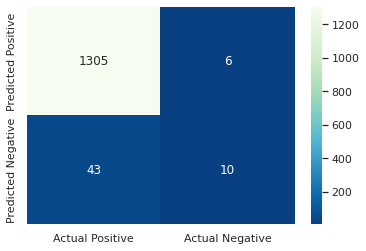

In [ ]:
#Gradient Boosted Trees

# Fit the model
randreg.fit(X_train_1,y_train_1)

# Predict test set results
y_pred = randreg.predict(X_test_1)

# Accuracy score
print("Accuracy: " + str(acc_score(randreg, X_train_1, y_train_1)))

# Classification report
from sklearn.metrics import classification_report
print("Classification Report", classification_report(y_test_1, y_predicted_randreg))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_1, y_predicted_randreg)
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive', 'Actual Negative'], 
                                 index=['Predicted Positive', 'Predicted Negative'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'GnBu_r')


In [ ]:
#Extra Trees
ETreg_init = ExtraTreesClassifier()

cvet = GridSearchCV(ETreg_init,parameters,cv=5)
cvet.fit(X_train_1,y_train_1.values.ravel())
display(cvet)

#Based on parameter tuning above
ETreg = ExtraTreesClassifier(criterion="gini",max_features=21,n_estimators=100);

# Fit data on to the model
ETreg.fit(X_train_1, y_train_1)

# Predict
y_predicted_ETreg = ETreg.predict(X_test_1)

Best parameters are: {'criterion': 'gini', 'max_depth': 32, 'max_features': 5, 'n_estimators': 50}


0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 5}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 10}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 50}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 100}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'n_estimators': 250}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 5}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
0.969 + or -0.0 for the {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimat

In [ ]:
print("Accuracy: " + str(acc_score(ETreg, X_train_1, y_train_1)))
ETacc=acc_score(ETreg, X_train_1, y_train_1)
#confusion_matrix_model(ETreg, X_train_1, y_train_1)

Accuracy: 0.9706691109074244


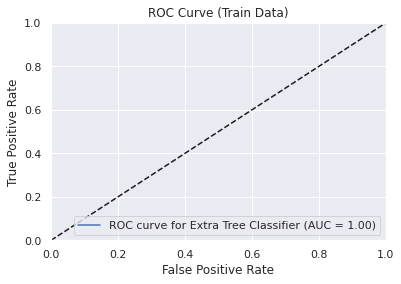

In [ ]:
plt_roc_curve("Extra Tree Classifier", ETreg, X_train_1, y_train_1, has_proba=True)

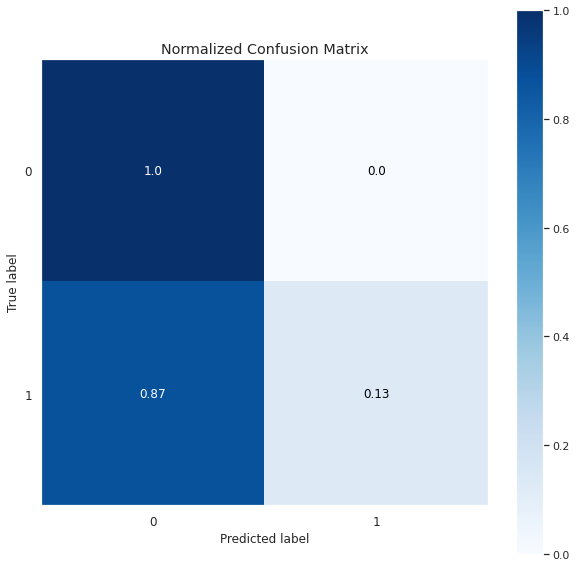

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test_1, ETreg.predict(X_test_1),normalize=True, figsize=(10,10))

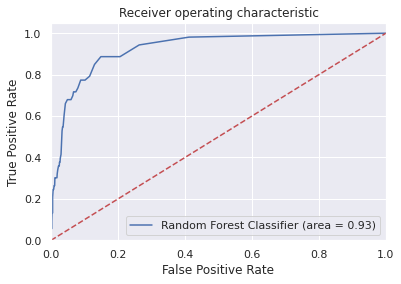

In [ ]:
logit_roc_auc = roc_auc_score(y_test_1, ETreg.predict_proba(X_test_1)[:,1])
fpr, tpr, thresholds = roc_curve(y_test_1, ETreg.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

4. Conduct hyperparameter tuning for the following at a minimum:  
n_estimators (number of trees)  
max_features (maximum features considered for splitting a node)  
max_depth (maximum number of levels in each tree)  
splitting criteria (entropy or gini)

4. Compare your models using the F1-Score on a 20% validation set.